<a href="https://colab.research.google.com/github/FrancescoParisi02/NLP-task-in-BERT/blob/main/BERT_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install transformers
!pip install torch
!pip install seaborn
!pip install tqdm
!pip install matplotlib

In [2]:
import os
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("ankurzing/aspect-based-sentiment-analysis-for-financial-news")
file_path = os.path.join(path, "SEntFiN-v1.1.csv")

df = pd.read_csv(file_path)
print(df.head())

   S No.                                              Title  \
0      1  SpiceJet to issue 6.4 crore warrants to promoters   
1      2                  MMTC Q2 net loss at Rs 10.4 crore   
2      3  Mid-cap funds can deliver more, stay put: Experts   
3      4             Mid caps now turn into market darlings   
4      5  Market seeing patience, if not conviction: Pra...   

                       Decisions  Words  
0        {"SpiceJet": "neutral"}      8  
1            {"MMTC": "neutral"}      8  
2  {"Mid-cap funds": "positive"}      8  
3       {"Mid caps": "positive"}      7  
4          {"Market": "neutral"}      8  


In [3]:
# Contare le occorrenze per classe
# Classe neutral, Classe negative, Classe positive

# Estrai i valori (positive, neutral, negative) dalla colonna Decisions
# I valore positive, negative, neutral si estraggono da una colonna NLP che si chiama Sentiment
df['Sentiment'] = df['Decisions'].apply(lambda x: eval(x).values()).apply(list).str[0]

# Conta gli elementi per tipo
counts = df['Sentiment'].value_counts()

print("Conteggio per tipo di sentiment:")
print(counts)

Conteggio per tipo di sentiment:
Sentiment
positive    4170
neutral     3444
negative    3139
Name: count, dtype: int64


In [4]:
# Uniforma il numero di campioni per classe
from sklearn.utils import resample

# Trova il numero minimo di campioni tra le classi
min_count = df['Sentiment'].value_counts().min()

# Crea un DataFrame per ogni classe
classes = df['Sentiment'].unique()
balanced_dfs = []

for sentiment_class in classes:
    class_df = df[df['Sentiment'] == sentiment_class]
    balanced_df = class_df.sample(n=min_count, random_state=42)  # Campiona min_count elementi
    balanced_dfs.append(balanced_df)

# Combina i DataFrame bilanciati
balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)

# Verifica il nuovo conteggio delle classi
print("Conteggio bilanciato per tipo di sentiment:")
print(balanced_df['Sentiment'].value_counts())


Conteggio bilanciato per tipo di sentiment:
Sentiment
neutral     3139
positive    3139
negative    3139
Name: count, dtype: int64


In [5]:
import re
import nltk
from nltk.corpus import stopwords

import zipfile
with zipfile.ZipFile("stopwords.zip", "r") as zip_ref:
    zip_ref.extractall("nltk_data/corpora")  # Estrai nella directory "nltk_data/corpora"

# Ottieni l'elenco delle stopwords in inglese
import nltk
nltk.data.path.append("./nltk_data")  # Aggiungi il percorso personalizzato

# Verifica che le stopwords siano disponibili
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # Converte il testo in minuscolo
    text = text.lower()

    # Rimuove link
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Rimuove caratteri speciali e punteggiatura
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Rimuove numeri
    text = re.sub(r"\d+", "", text)

    # Rimuove spazi multipli
    text = re.sub(r"\s+", " ", text).strip()

    # Rimuove stopwords in inglese
    words = text.split()  # Tokenizza il testo in parole
    filtered_words = [word for word in words if word not in stop_words]
    text = " ".join(filtered_words)  # Ricompone il testo senza stopwords

    return text

# Crea una nuova colonna 'Title' con la versione di 'Title' senza stopwords
df_cleaned = df.copy()  # Crea una copia del DataFrame originale
df_cleaned["Title"] = df_cleaned["Title"].apply(clean_text)

print(df_cleaned.head())


   S No.                                            Title  \
0      1          spicejet issue crore warrants promoters   
1      2                         mmtc q net loss rs crore   
2      3            midcap funds deliver stay put experts   
3      4                    mid caps turn market darlings   
4      5  market seeing patience conviction prakash diwan   

                       Decisions  Words Sentiment  
0        {"SpiceJet": "neutral"}      8   neutral  
1            {"MMTC": "neutral"}      8   neutral  
2  {"Mid-cap funds": "positive"}      8  positive  
3       {"Mid caps": "positive"}      7  positive  
4          {"Market": "neutral"}      8   neutral  


In [6]:
from transformers import BertTokenizer

# Tokenizza il testo e prepara input IDs e attention masks
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Funzione per capire come vengono tokenizzati i titoli
def tokenize_titles(df):
    tokenized_dfs = []

    for index, row in df.iterrows():
        title = row["Title"]  # Estrai il titolo
        tokens = tokenizer.tokenize(title)  # Tokenizza il testo
        token_ids = tokenizer.convert_tokens_to_ids(tokens)  # Ottieni gli ID dei token

        # Crea un DataFrame per il titolo corrente
        tokenized_df = pd.DataFrame({
            "Tokens": tokens,
            "Token IDs": token_ids
        })

        # Aggiungi il numero della riga di origine
        tokenized_df["N.ro Row"] = index

        # Aggiungi alla lista dei DataFrame
        tokenized_dfs.append(tokenized_df)

    # Combina tutti i DataFrame in un'unica tabella
    result_df = pd.concat(tokenized_dfs, ignore_index=True)
    return result_df

# Applica la funzione al tuo DataFrame
tokenized_result = tokenize_titles(df_cleaned)

# Mostra la tabella risultante
print(tokenized_result)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


         Tokens  Token IDs  N.ro Row
0         spice      17688         0
1         ##jet      15759         0
2         issue       3277         0
3         crore      21665         0
4       warrant      10943         0
...         ...        ...       ...
110750   shares       6661     10752
110751     flat       4257     10752
110752   energy       2943     10752
110753     drag       8011     10752
110754      ##s       2015     10752

[110755 rows x 3 columns]


In [7]:
# Estrai i titoli dal DataFrame
titles = df_cleaned['Title'].tolist()

# Calcola la lunghezza dei token per ogni titolo per capire a quanto impostare il padding
token_lengths = [len(tokenizer.tokenize(title)) for title in titles]

# Lunghezza massima e media
max_length = max(token_lengths)
mean_length = sum(token_lengths) / len(token_lengths)

print(f"Lunghezza massima delle frasi: {max_length}")
print(f"Lunghezza media delle frasi: {mean_length:.2f}")

Lunghezza massima delle frasi: 27
Lunghezza media delle frasi: 10.30


In [8]:
from sklearn.model_selection import train_test_split
import torch

def prepare_inputs(df, max_length):
    input_ids = []
    attention_masks = []
    for title in df['Title']:
        encoded = tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# 13 è un buon compromesso
max_length = 15
input_ids, attention_masks = prepare_inputs(df_cleaned, max_length)

# Dividi in training e test
y = df_cleaned['Sentiment']
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids, attention_masks, y, test_size=0.2, random_state=42, stratify=y
)

# Resetta gli indici per evitare disallineamenti
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Mappa le etichette a numeri
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

# Conta i campioni per tipo nel training set
train_counts = y_train.value_counts()

# Conta i campioni per tipo nel test set
test_counts = y_test.value_counts()

# Stampa i risultati
print("Conteggio per tipo di sentiment nel training set:")
print(train_counts)

print("\nConteggio per tipo di sentiment nel test set:")
print(test_counts)

Conteggio per tipo di sentiment nel training set:
Sentiment
2    3336
1    2755
0    2511
Name: count, dtype: int64

Conteggio per tipo di sentiment nel test set:
Sentiment
2    834
1    689
0    628
Name: count, dtype: int64


In [9]:
from torch.utils.data import Dataset, DataLoader

# Supponendo che il tuo DataFrame df_cleaned sia già stato processato
# E hai input_ids, attention_masks, e y pronti

class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)  # Specifica il tipo long

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "label": self.labels[idx]
        }

# Dataset per training e test
train_dataset = SentimentDataset(X_train_ids, X_train_masks, y_train)
test_dataset = SentimentDataset(X_test_ids, X_test_masks, y_test)

# Crea DataLoader
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
import torch
from transformers import BertForSequenceClassification, AdamW, get_scheduler

# Inizializza il modello BERT per classificazione
num_labels = 3  # Numero di classi (positive, neutral, negative)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Sposta il modello sulla GPU se disponibile
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Inizializza l'ottimizzatore e lo scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Liste per salvare accuracies e loss
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

model.train()
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Variabili per calcolare l'accuratezza e la loss durante il training
    train_predictions = []
    train_labels = []
    epoch_train_loss = 0  # Inizializza la loss di training per l'epoca

    for batch in train_dataloader:
        # Sposta i dati sulla GPU/CPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Calcola gli output del modello
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Predizioni del modello
        predictions = torch.argmax(logits, dim=-1)
        train_predictions.extend(predictions.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        # Accumula la loss per questa epoca
        epoch_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Calcola e salva la media della loss e l'accuratezza per il training
    train_losses.append(epoch_train_loss / len(train_dataloader))
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies.append(train_accuracy)

    # Valutazione sul validation set
    model.eval()
    val_predictions = []
    val_labels = []
    epoch_val_loss = 0  # Inizializza la loss di validazione per l'epoca

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Predizioni del modello
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumula la loss per la validazione
            epoch_val_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calcola e salva la media della loss e l'accuratezza per la validazione
    val_losses.append(epoch_val_loss / len(test_dataloader))
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_accuracies.append(val_accuracy)

  0%|          | 0/5380 [00:00<?, ?it/s]

Epoch 1/10


 10%|█         | 541/5380 [00:41<23:11,  3.48it/s]

Epoch 2/10


 20%|██        | 1077/5380 [01:22<28:14,  2.54it/s]

Epoch 3/10


 30%|███       | 1617/5380 [02:03<18:27,  3.40it/s]

Epoch 4/10


 40%|████      | 2155/5380 [02:44<15:40,  3.43it/s]

Epoch 5/10


 50%|█████     | 2693/5380 [03:25<12:56,  3.46it/s]

Epoch 6/10


 60%|██████    | 3231/5380 [04:06<10:21,  3.46it/s]

Epoch 7/10


 70%|███████   | 3769/5380 [04:46<07:45,  3.46it/s]

Epoch 8/10


 80%|████████  | 4307/5380 [05:27<05:10,  3.46it/s]

Epoch 9/10


 90%|█████████ | 4845/5380 [06:08<02:34,  3.47it/s]

Epoch 10/10


100%|█████████▉| 5379/5380 [06:46<00:00, 14.05it/s]

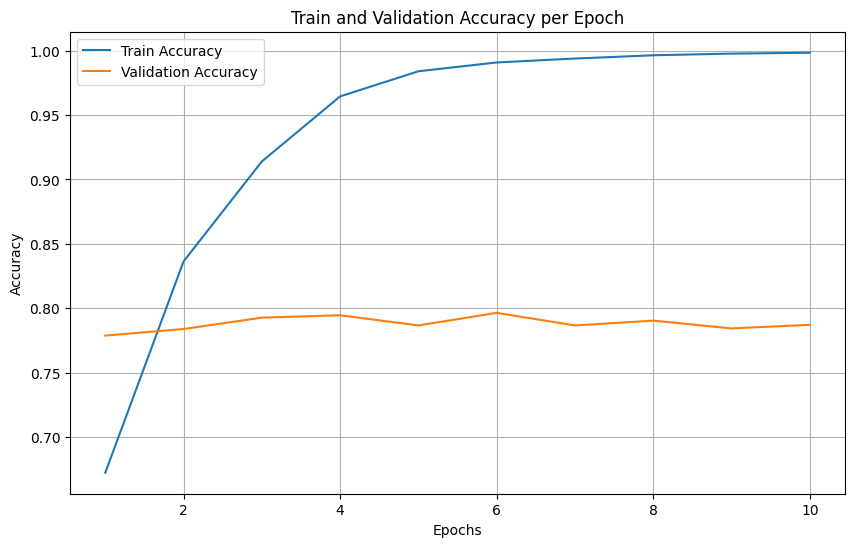

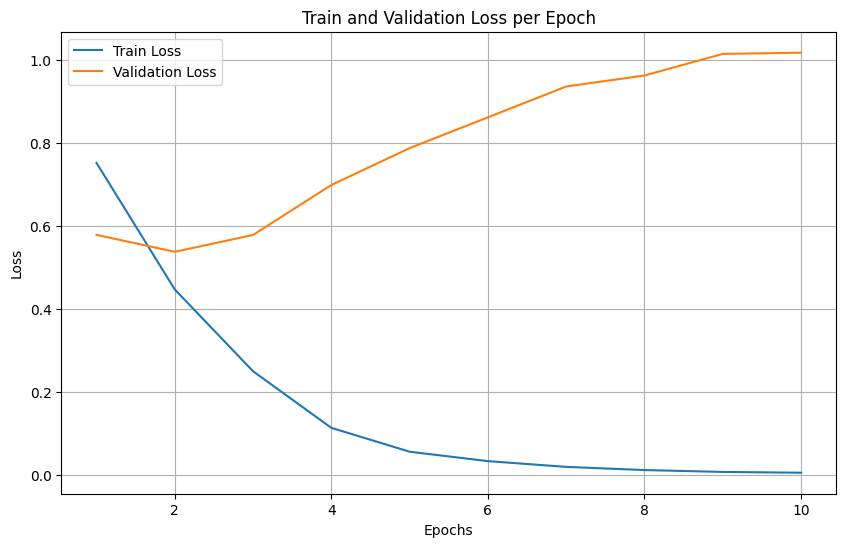

Test Accuracy: 0.7871


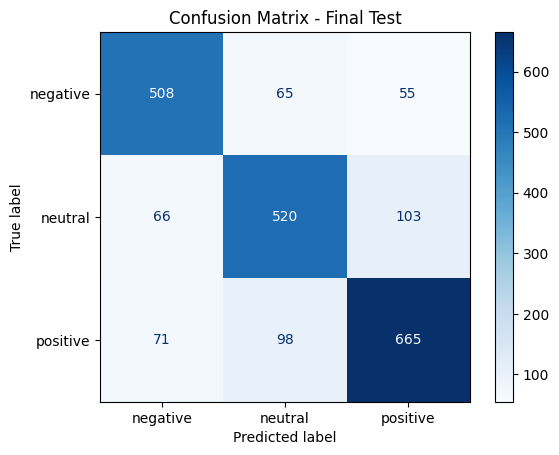

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot delle accuratezze
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy per Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot delle loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

# Calcola l'accuratezza finale sul set di test
test_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Matrice di confusione finale
cm_final = confusion_matrix(val_labels, val_predictions, labels=[0, 1, 2])
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=["negative", "neutral", "positive"])
disp_final.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Test")
plt.show()